## Assignment : 14

<pre>
1. You can work with preprocessed_data.csv for the assignment. You can get the data from - <a href='https://drive.google.com/drive/u/0/folders/1CJnItndeSSJu7aragQoXWZS9-0apN6pp'>Data folder </a>
2. Load the data in your notebook.
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a  href='https://stackoverflow.com/a/46844409'>this</a> and <a  href='https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/80807'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum.
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in a separate pad and write your observations about them.
8. Make sure that you are using GPU to train the given models.
</pre>

In [ ]:
#you can use gdown modules to import dataset for the assignment
#for importing any file from drive to Colab you can write the syntax as !gdown --id file_id
#you can run the below cell to import the required preprocessed data.csv file and glove vector

In [ ]:
#!gdown --id 1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv-
#!gdown --id 1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_

## <font color='red'> Model-1 </font>
Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
#input_layer = Input(shape=(n,))
#embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
#flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

# <font color='red'> Model-1 </font>

In [1]:
# import all the libraries
#make sure that you import your libraries from tf.keras and not just keras
import tensorflow
from tensorflow.keras.layers import Input,Dense,LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout, Embedding, Flatten, concatenate, Conv1D
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [3]:
#read the csv file

df = pd.read_csv(r'/kaggle/input/donors-choose/preprocessed_data.csv')
df.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [4]:
X = df.drop(['project_is_approved'],axis=1)
y = df['project_is_approved']

In [5]:
# perform stratified train test split on the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

In [6]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(53531, 8) (53531,)
(22942, 8) (22942,)
(32775, 8) (32775,)


## 1.1 Text Vectorization

In [7]:
#since the data is already preprocessed, we can directly move to vectorization part
#first we will vectorize the text data
#for vectorization of text data in deep learning we use tokenizer, you can go through below references
# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
#https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
# after text vectorization you should get train_padded_docs and test_padded_docs

### Essay

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train['essay'].values)

# Vocab Size
vocab_size_1 = len(tokenizer.word_index) + 1

# Encode training data sentences into sequences
X_train_essay_seq = tokenizer.texts_to_sequences(X_train['essay'].values)
X_cv_essay_seq = tokenizer.texts_to_sequences(X_cv['essay'].values)
X_test_essay_seq = tokenizer.texts_to_sequences(X_test['essay'].values)

lnth = max([len(i) for i in X_train_essay_seq])

# Pad the training sequences
X_train_essay_pad = pad_sequences(X_train_essay_seq, padding='post', maxlen=lnth)
X_cv_essay_pad = pad_sequences(X_cv_essay_seq, padding='post', maxlen=lnth)
X_test_essay_pad = pad_sequences(X_test_essay_seq, padding='post', maxlen=lnth)

In [9]:
#after getting the padded_docs you have to use predefined glove vectors to get 300 dim representation for each word
# we will be storing this data in form of an embedding matrix and will use it while defining our model
# Please go through following blog's 'Example of Using Pre-Trained GloVe Embedding' section to understand how to create embedding matrix
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/



In [10]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(r'/kaggle/input/glove42b300dtxt/glove.42B.300d.txt', encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 1.2 Categorical feature Vectorization

In [11]:
# for model 1 and model 2, we have to assign a unique number to each feature in a particular categorical column.
# you can either use tokenizer,label encoder or ordinal encoder to perform the task
# label encoder gives an error for 'unseen values' (values present in test but not in train)
# handle unseen values with label encoder - https://stackoverflow.com/a/56876351
# ordinal encoder also gives error with unseen values but you can use modify handle_unknown parameter
# documentation of ordianl encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
# after categorical feature vectorization you will have column_train_data and column_test_data.


### School State

In [12]:
from sklearn.preprocessing import LabelEncoder

tokenizer_2 = LabelEncoder()
tokenizer_2.fit(X_train['school_state'].values)

# Vocab Size
vocab_size_2 = len(tokenizer_2.classes_) + 1

X_train_school_state = tokenizer_2.transform(X_train['school_state'].values)
X_cv_school_state = tokenizer_2.transform(X_cv['school_state'].values)
X_test_school_state = tokenizer_2.transform(X_test['school_state'].values)

embedding_size_school_state = min(vocab_size_2, 50)

### Project Grade Category

In [13]:
tokenizer_3 = LabelEncoder()
tokenizer_3.fit(X_train['project_grade_category'].values)

# Vocab Size
vocab_size_3 = len(tokenizer_3.classes_) + 1

X_train_project_grade = tokenizer_3.transform(X_train['project_grade_category'].values)
X_cv_project_grade = tokenizer_3.transform(X_cv['project_grade_category'].values)
X_test_project_grade = tokenizer_3.transform(X_test['project_grade_category'].values)

embedding_size_project_grade = min(vocab_size_3, 50)

### Clean Categories

In [14]:
# Tokenize data
tokenizer_4 = LabelEncoderExt()
tokenizer_4.fit(X_train['clean_categories'].values)

# Vocab Size
vocab_size_4 = len(tokenizer_4.classes_) + 1

# Encode training data sentences into sequences
X_train_clean_cat = tokenizer_4.transform(X_train['clean_categories'].values)
X_cv_clean_cat = tokenizer_4.transform(X_cv['clean_categories'].values)
X_test_clean_cat = tokenizer_4.transform(X_test['clean_categories'].values)

embedding_size_clean_cat = min(vocab_size_4, 50)

### Clean Subcategories

In [15]:
# Tokenize data
tokenizer_5 = LabelEncoderExt()
tokenizer_5.fit(X_train['clean_subcategories'].values)

# Vocab Size
vocab_size_5 = len(tokenizer_5.classes_) + 1

X_train_clean_subcat = tokenizer_5.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcat = tokenizer_5.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcat = tokenizer_5.transform(X_test['clean_subcategories'].values)

embedding_size_clean_subcat = min(vocab_size_5, 50)

### Teacher Prefix

In [16]:
# Tokenize data
tokenizer_6 = LabelEncoder()
tokenizer_6.fit(X_train['teacher_prefix'].values)

# Vocab Size
vocab_size_6 = len(tokenizer_6.classes_) + 1
X_train_teacher_pre = tokenizer_6.transform(X_train['teacher_prefix'].values)
X_cv_teacher_pre = tokenizer_6.transform(X_cv['teacher_prefix'].values)
X_test_teacher_pre = tokenizer_6.transform(X_test['teacher_prefix'].values)

embedding_size_teacher_prefix = min(vocab_size_6, 50)

## 1.3 Numerical feature Vectorization

In [17]:
# you have to standardise the numerical columns
# stack both the numerical features
#after numerical feature vectorization you will have numerical_data_train and numerical_data_test

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_num_projects = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_num_projects = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_num_projects = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


Scaler = StandardScaler()
Scaler.fit(X_train['price'].values.reshape(-1,1))

X_train_price = Scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = Scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = Scaler.transform(X_test['price'].values.reshape(-1,1))

X_train_numeric_features = np.concatenate((X_train_num_projects , X_train_price) , axis = 1)
X_cv_numeric_features = np.concatenate((X_cv_num_projects , X_cv_price) , axis = 1)
X_test_numeric_features = np.concatenate((X_test_num_projects , X_test_price) , axis = 1)

print(X_train_numeric_features.shape , X_cv_numeric_features.shape, X_test_numeric_features.shape)

(53531, 2) (22942, 2) (32775, 2)


## 1.4 Defining the model

<img src='https://i.imgur.com/w395Yk9.png'>

In [19]:
# as of now we have vectorized all our features now we will define our model.
# as it is clear from above image that the given model has multiple input layers and hence we have to use functional API
# Please go through - https://keras.io/guides/functional_api/
# it is a good programming practise to define your complete model i.e all inputs , intermediate and output layers at one place.
# while defining your model make sure that you use variable names while defining any length,dimension or size.
#for ex.- you should write the code as 'input_text = Input(shape=(pad_length,))' and not as 'input_text = Input(shape=(300,))'
# the embedding layer for text data should be non trainable
# the embedding layer for categorical data should be trainable
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0
#print model.summary() after you have defined the model
#plot the model using utils.plot_model module and make sure that it is similar to the above image

In [20]:
essay = Input(shape=(lnth,), name="essay")
essay_embed = Embedding(vocab_size_1, 300, weights=[embedding_matrix], trainable=False)(essay)
essay_feature = LSTM(100, kernel_regularizer=l2(0.0001), dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(essay_embed)
Flatten_1 = Flatten()(essay_feature)

school_state = Input((1,), name='school_state')
school_state_emb = Embedding(input_dim =vocab_size_2, output_dim=embedding_size_school_state)(school_state) 
Flatten_2 = Flatten()(school_state_emb)

project_grade_category = Input(shape=(1,), name="project_grade_category")
project_grade_category_emb = Embedding(input_dim =vocab_size_3, output_dim=embedding_size_project_grade)(project_grade_category)
Flatten_3 = Flatten()(project_grade_category_emb)

clean_categories = Input(shape=(1,), name="clean_categories")
clean_categories_emb = Embedding(input_dim=vocab_size_4, output_dim=embedding_size_clean_cat)(clean_categories)
Flatten_4 = Flatten()(clean_categories_emb)

clean_subcategories = Input(shape=(1,), name="clean_subcategories")
clean_subcategories_emb = Embedding(input_dim=vocab_size_5, output_dim=embedding_size_clean_subcat)(clean_subcategories)
Flatten_5 = Flatten()(clean_subcategories_emb)

teacher_prefix = Input(shape=(1,), name="teacher_prefix")
teacher_prefix_emb = Embedding(input_dim=vocab_size_6, output_dim=embedding_size_teacher_prefix)(teacher_prefix)
Flatten_6 = Flatten()(teacher_prefix_emb)

numeric_features = Input(shape=(2,) , name="numerical_features")
numeric_dense = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(numeric_features )

# Concatination all layers
concat = concatenate([Flatten_1, Flatten_2, Flatten_3, Flatten_4, Flatten_5, Flatten_6, numeric_dense])

dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(concat)
drop_out_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(drop_out_1)
drop_out_2 = Dropout(0.3)(dense_2)

dense_3 = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(drop_out_2)
output = Dense(2, activation='softmax')(dense_3)

2023-01-18 21:35:46.100332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:35:46.101769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:35:46.120522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:35:46.121890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:35:46.123086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## 1.5 Compiling and fititng your model

In [21]:
#define custom auc as metric , do not use tf.keras.metrics
# https://stackoverflow.com/a/46844409 - custom AUC reference 1
# https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/80807  - custom AUC reference 2
# compile and fit your model

In [22]:
from tensorflow.keras.models import Model

model_1 = Model(inputs=[essay, school_state, project_grade_category, clean_categories, clean_subcategories, teacher_prefix, numeric_features],outputs=[output])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay (InputLayer)              [(None, 333)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 333, 300)     12797100    essay[0][0]                      
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa [(None, 1)]          0                                            
______________________________________________________________________________________________

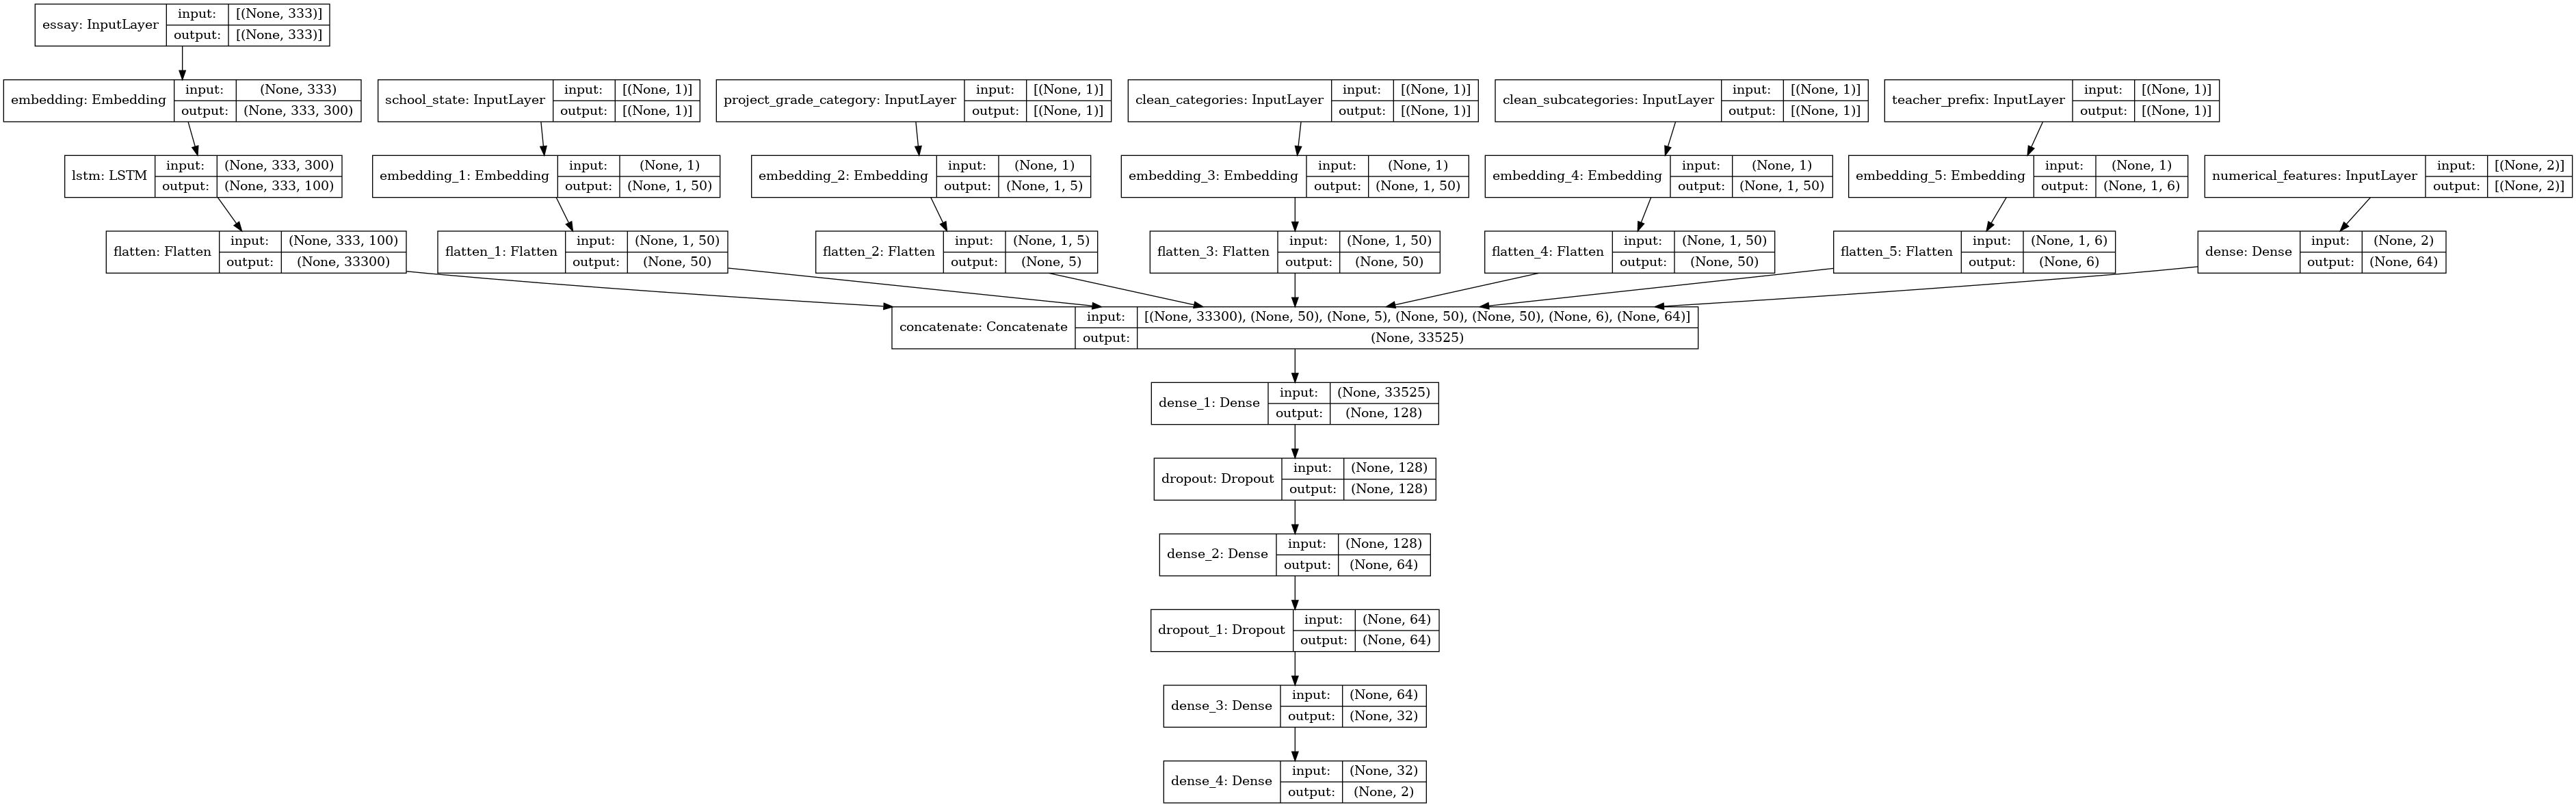

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, "LSTM_1.png", show_shapes=True)

In [24]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [25]:
y_train_ohe = pd.get_dummies(y_train)
y_cv_ohe = pd.get_dummies(y_cv)
y_test_ohe = pd.get_dummies(y_test)

In [26]:
train_data = [X_train_essay_pad, X_train_school_state, X_train_project_grade, X_train_clean_cat,
              X_train_clean_subcat, X_train_teacher_pre, X_train_numeric_features]

cv_data = [X_cv_essay_pad, X_cv_school_state, X_cv_project_grade, X_cv_clean_cat,
              X_cv_clean_subcat, X_cv_teacher_pre, X_cv_numeric_features]

test_data = [X_test_essay_pad, X_test_school_state, X_test_project_grade, X_test_clean_cat,
            X_test_clean_subcat, X_test_teacher_pre, X_test_numeric_features]

In [27]:
model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=[auc])

In [28]:
history_1 = model_1.fit(train_data, y_train_ohe, batch_size=128, epochs=5, validation_data=(test_data, y_test_ohe)) 

2023-01-18 21:35:49.377760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
419/419 [==============================] - 752s 2s/step - loss: 2.2226 - auc: 0.6750 - val_loss: 1.2798 - val_auc: 0.7241
Epoch 2/5
419/419 [==============================] - 754s 2s/step - loss: 0.9928 - auc: 0.7223 - val_loss: 0.7938 - val_auc: 0.7417
Epoch 3/5
419/419 [==============================] - 745s 2s/step - loss: 0.6775 - auc: 0.7336 - val_loss: 0.5866 - val_auc: 0.7500
Epoch 4/5
419/419 [==============================] - 745s 2s/step - loss: 0.5268 - auc: 0.7393 - val_loss: 0.4795 - val_auc: 0.7508
Epoch 5/5
419/419 [==============================] - 741s 2s/step - loss: 0.4537 - auc: 0.7426 - val_loss: 0.4261 - val_auc: 0.7576


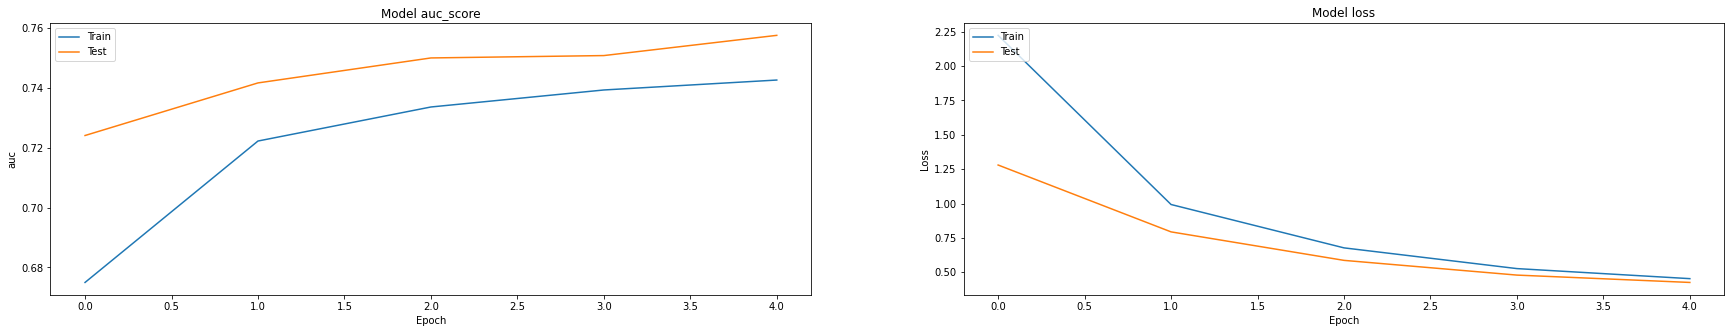

In [29]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_1.history['auc'])
plt.plot(history_1.history['val_auc'])
plt.title('Model auc_score')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# <font color='red'> Model-2 </font>

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Fit TF-IDF vectorizer on the Train data <br>
2. Get the idf value for each word we have in the train data. Please go through <a  href='https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer'>this</a><br>

3. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very 
frequent words and very very rare words don't give much information.
Hint - A preferable IDF range is 2-11 for model 2. <br>
4.Remove the low idf value and high idf value words from the train and test data. You can go through each of the
sentence of train and test data and include only those features(words) which are present in the defined IDF range.
5. Perform tokenization on the modified text data same as you have done for previous model.
6. Create embedding matrix for model 2 and then use the rest of the features similar to previous model.
7. Define the model, compile and fit the model.
</pre>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X_train["essay"])

# Calculating the idf values
data = {'word': vectorizer.get_feature_names() , 'idf': vectorizer.idf_}
df_ = pd.DataFrame(data)

res = ((df_['idf'] >= 2) & (df_['idf'] <= 11))

# Filter the data
tfidf_prefer = df_[res]
print(tfidf_prefer.shape)

words_tfidf = tfidf_prefer['word'].tolist()

(26222, 2)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
tokenizer_7 = Tokenizer(num_words=50000)
tokenizer_7.fit_on_texts(words_tfidf)

# Vocab Size
vocab_size_7 = len(tokenizer_7.word_index) + 1

# Encode training data sentences into sequences
X_train_essay_seq_2 = tokenizer_7.texts_to_sequences(X_train['essay'].values)
X_cv_essay_seq_2 = tokenizer_7.texts_to_sequences(X_cv['essay'].values)
X_test_essay_seq_2 = tokenizer_7.texts_to_sequences(X_test['essay'].values)

length = max([len(i) for i in X_train_essay_seq_2])

# Pad the training sequences
X_train_essay_pad_2 = pad_sequences(X_train_essay_seq_2, padding='post', maxlen=length)
X_cv_essay_pad_2 = pad_sequences(X_cv_essay_seq_2, padding='post', maxlen=length)
X_test_essay_pad_2 = pad_sequences(X_test_essay_seq_2, padding='post', maxlen=length)

In [35]:
# load the whole embedding into memory
embeddings_index_1 = dict()
f = open(r'/kaggle/input/glove42b300dtxt/glove.42B.300d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_1[word] = coefs
f.close()

# create a weight matrix for words in training docs
embedding_matrix_1 = np.zeros((vocab_size_7, 300))
for word, i in tokenizer_7.word_index.items():
    embedding_vector_1 = embeddings_index_1.get(word)
    if embedding_vector_1 is not None:
        embedding_matrix_1[i] = embedding_vector_1

In [36]:
essay = Input(shape=(length,), name="essay")
essay_embed = Embedding(vocab_size_7, 300, weights=[embedding_matrix_1], trainable=False)(essay)
essay_feature = LSTM(100, kernel_regularizer=l2(0.0001), dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(essay_embed)
Flatten_1 = Flatten()(essay_feature)

school_state = Input((1,), name='school_state')
school_state_emb = Embedding(input_dim =vocab_size_2, output_dim=embedding_size_school_state)(school_state) 
Flatten_2 = Flatten()(school_state_emb)

project_grade_category = Input(shape=(1,), name="project_grade_category")
project_grade_category_emb = Embedding(input_dim =vocab_size_3, output_dim=embedding_size_project_grade)(project_grade_category)
Flatten_3 = Flatten()(project_grade_category_emb)

clean_categories = Input(shape=(1,), name="clean_categories")
clean_categories_emb = Embedding(input_dim=vocab_size_4, output_dim=embedding_size_clean_cat)(clean_categories)
Flatten_4 = Flatten()(clean_categories_emb)

clean_subcategories = Input(shape=(1,), name="clean_subcategories")
clean_subcategories_emb = Embedding(input_dim=vocab_size_5, output_dim=embedding_size_clean_subcat)(clean_subcategories)
Flatten_5 = Flatten()(clean_subcategories_emb)

teacher_prefix = Input(shape=(1,), name="teacher_prefix")
teacher_prefix_emb = Embedding(input_dim=vocab_size_6, output_dim=embedding_size_teacher_prefix)(teacher_prefix)
Flatten_6 = Flatten()(teacher_prefix_emb)

numeric_features = Input(shape=(2,) , name="numerical_features")
numeric_dense = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(numeric_features )

# Concatination all layers
concat = concatenate([Flatten_1, Flatten_2, Flatten_3, Flatten_4, Flatten_5, Flatten_6, numeric_dense])

dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(concat)
drop_out_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(drop_out_1)
drop_out_2 = Dropout(0.3)(dense_2)

dense_3 = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(drop_out_2)
output = Dense(2, activation='softmax')(dense_3)

In [38]:
from tensorflow.keras.models import Model

model_2 = Model(inputs=[essay, school_state, project_grade_category, clean_categories, clean_subcategories, teacher_prefix, numeric_features],outputs=[output])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay (InputLayer)              [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 294, 300)     7866900     essay[0][0]                      
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa [(None, 1)]          0                                            
____________________________________________________________________________________________

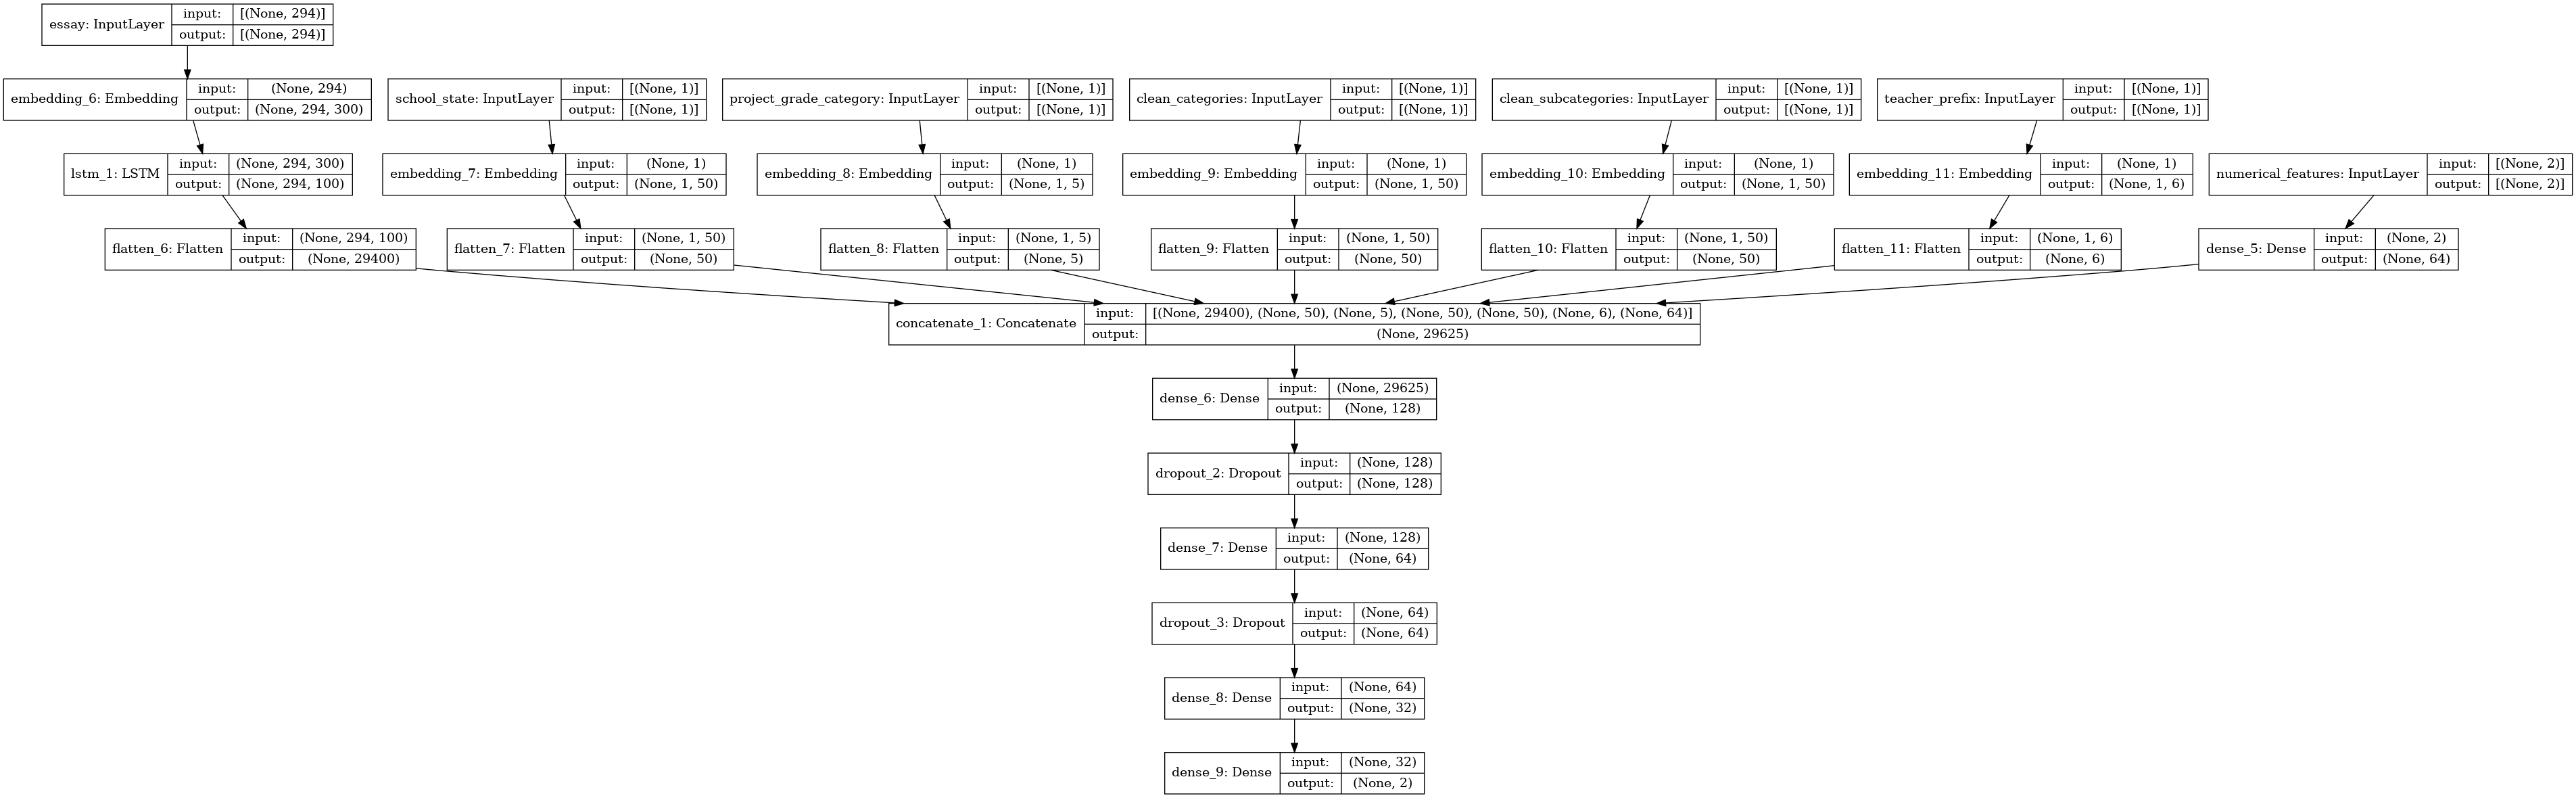

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, "LSTM_2.png", show_shapes=True)

In [40]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [41]:
train_data_2 = [X_train_essay_pad_2, X_train_school_state, X_train_project_grade, X_train_clean_cat,
              X_train_clean_subcat, X_train_teacher_pre, X_train_numeric_features]

cv_data_2 = [X_cv_essay_pad_2, X_cv_school_state, X_cv_project_grade, X_cv_clean_cat,
              X_cv_clean_subcat, X_cv_teacher_pre, X_cv_numeric_features]

test_data_2 = [X_test_essay_pad_2, X_test_school_state, X_test_project_grade, X_test_clean_cat,
            X_test_clean_subcat, X_test_teacher_pre, X_test_numeric_features]

In [42]:
model_2.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=[auc])

In [43]:
history_2 = model_2.fit(train_data_2, y_train_ohe, batch_size=128, epochs=8, validation_data=(cv_data_2, y_cv_ohe)) 

Epoch 1/8
419/419 [==============================] - 670s 2s/step - loss: 2.1201 - auc: 0.6743 - val_loss: 1.2251 - val_auc: 0.7239
Epoch 2/8
419/419 [==============================] - 661s 2s/step - loss: 0.9856 - auc: 0.7217 - val_loss: 0.8000 - val_auc: 0.7379
Epoch 3/8
419/419 [==============================] - 654s 2s/step - loss: 0.6858 - auc: 0.7299 - val_loss: 0.5879 - val_auc: 0.7440
Epoch 4/8
419/419 [==============================] - 664s 2s/step - loss: 0.5343 - auc: 0.7353 - val_loss: 0.4941 - val_auc: 0.7436
Epoch 5/8
419/419 [==============================] - 657s 2s/step - loss: 0.4574 - auc: 0.7394 - val_loss: 0.4330 - val_auc: 0.7411
Epoch 6/8
419/419 [==============================] - 659s 2s/step - loss: 0.4227 - auc: 0.7361 - val_loss: 0.4066 - val_auc: 0.7461
Epoch 7/8
419/419 [==============================] - 653s 2s/step - loss: 0.4089 - auc: 0.7379 - val_loss: 0.4054 - val_auc: 0.7435
Epoch 8/8
419/419 [==============================] - 635s 2s/step - loss: 0.

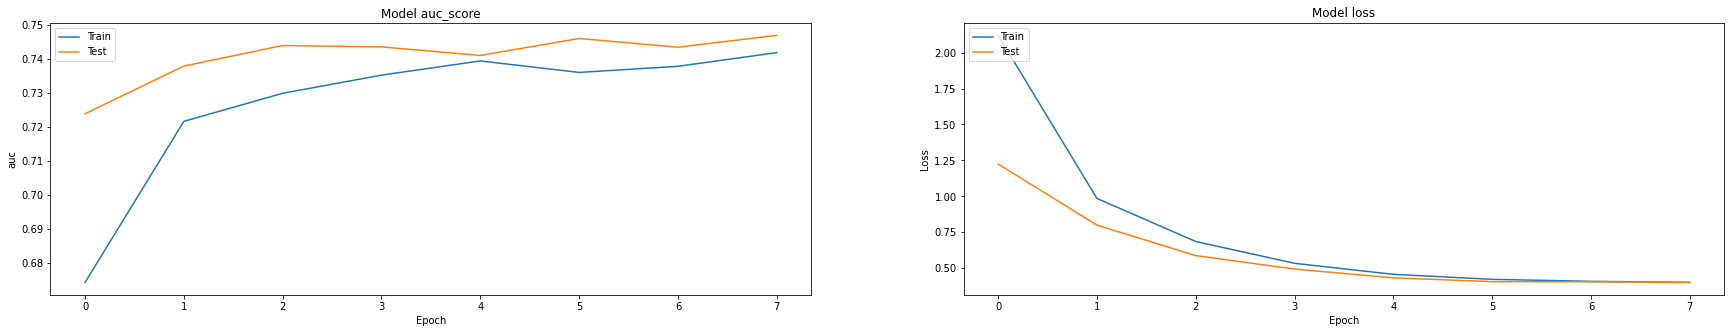

In [44]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_2.history['auc'])
plt.plot(history_2.history['val_auc'])
plt.title('Model auc_score')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# <font color='red'> Model-3 </font>

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [ ]:
#in this model you can use the text vectorized data from model1 
#for other than text data consider the following steps
# you have to perform one hot encoding of categorical features. You can use onehotencoder() or countvectorizer() for the same.
# Stack up standardised numerical features and all the one hot encoded categorical features
#the input to conv1d layer is 3d, you can convert your 2d data to 3d using np.newaxis
# Note - deep learning models won't work with sparse features, you have to convert them to dense features before fitting in the model.

### encoding categorical features: teacher_prefix

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(53531, 5) (53531,)
(22942, 5) (22942,)
(32775, 5) (32775,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### encoding categorical features: project_grade_category

In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(53531, 4) (53531,)
(22942, 4) (22942,)
(32775, 4) (32775,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### encoding categorical features: School State

In [48]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(53531, 51) (53531,)
(22942, 51) (22942,)
(32775, 51) (32775,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### encoding categorical features: clean_categories

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_cv_categories_ohe.shape, y_cv.shape)
print(X_test_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(53531, 9) (53531,)
(22942, 9) (22942,)
(32775, 9) (32775,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### encoding categorical features: clean_subcategories

In [50]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_cv_subcategories_ohe.shape, y_cv.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(53531, 30) (53531,)
(22942, 30) (22942,)
(32775, 30) (32775,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### encoding numerical features: price

In [51]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(53531, 1) (53531,)
(22942, 1) (22942,)
(32775, 1) (32775,)


### encoding numerical features: teacher_number_of_previously_posted_projects

In [52]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_nofprojects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_nofprojects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_nofprojects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_nofprojects_norm.shape, y_train.shape)
print(X_cv_nofprojects_norm.shape, y_cv.shape)
print(X_test_nofprojects_norm.shape, y_test.shape)

After vectorizations
(53531, 1) (53531,)
(22942, 1) (22942,)
(32775, 1) (32775,)


In [53]:
from scipy.sparse import hstack

X_tr = hstack((X_train_teacher_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_categories_ohe, 
                 X_train_subcategories_ohe, X_train_price_norm, X_train_nofprojects_norm)).todense()

X_cv = hstack((X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_state_ohe, X_cv_categories_ohe, 
                 X_cv_subcategories_ohe, X_cv_price_norm, X_cv_nofprojects_norm)).todense()

X_te = hstack((X_test_teacher_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_categories_ohe, 
                 X_test_subcategories_ohe, X_test_price_norm, X_test_nofprojects_norm)).todense()

print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

(53531, 101) (53531,)
(22942, 101) (22942,)
(32775, 101) (32775,)


In [54]:
essay = Input(shape=(lnth,), name="essay")
essay_embed = Embedding(vocab_size_1, 300, weights=[embedding_matrix], trainable=False)(essay)
essay_feature = LSTM(100, kernel_regularizer=l2(0.0001), dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(essay_embed)
flatten_1 = Flatten()(essay_feature)

input_data_cat = Input(shape=(101,1), name='other_than_text_data')
cov_1 = Conv1D(64, 3, activation='relu')(input_data_cat)
cov_2 = Conv1D(64, 3, activation='relu')(cov_1)
flatten_2 = Flatten()(cov_2)

con = concatenate([flatten_1, flatten_2])
dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(con)
dropout_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)

dense_3 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(dense_3)

model = Model(inputs=[essay, input_data_cat], outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay (InputLayer)              [(None, 333)]        0                                            
__________________________________________________________________________________________________
other_than_text_data (InputLaye [(None, 101, 1)]     0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 333, 300)     12797100    essay[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 99, 64)       256         other_than_text_data[0][0]       
____________________________________________________________________________________________

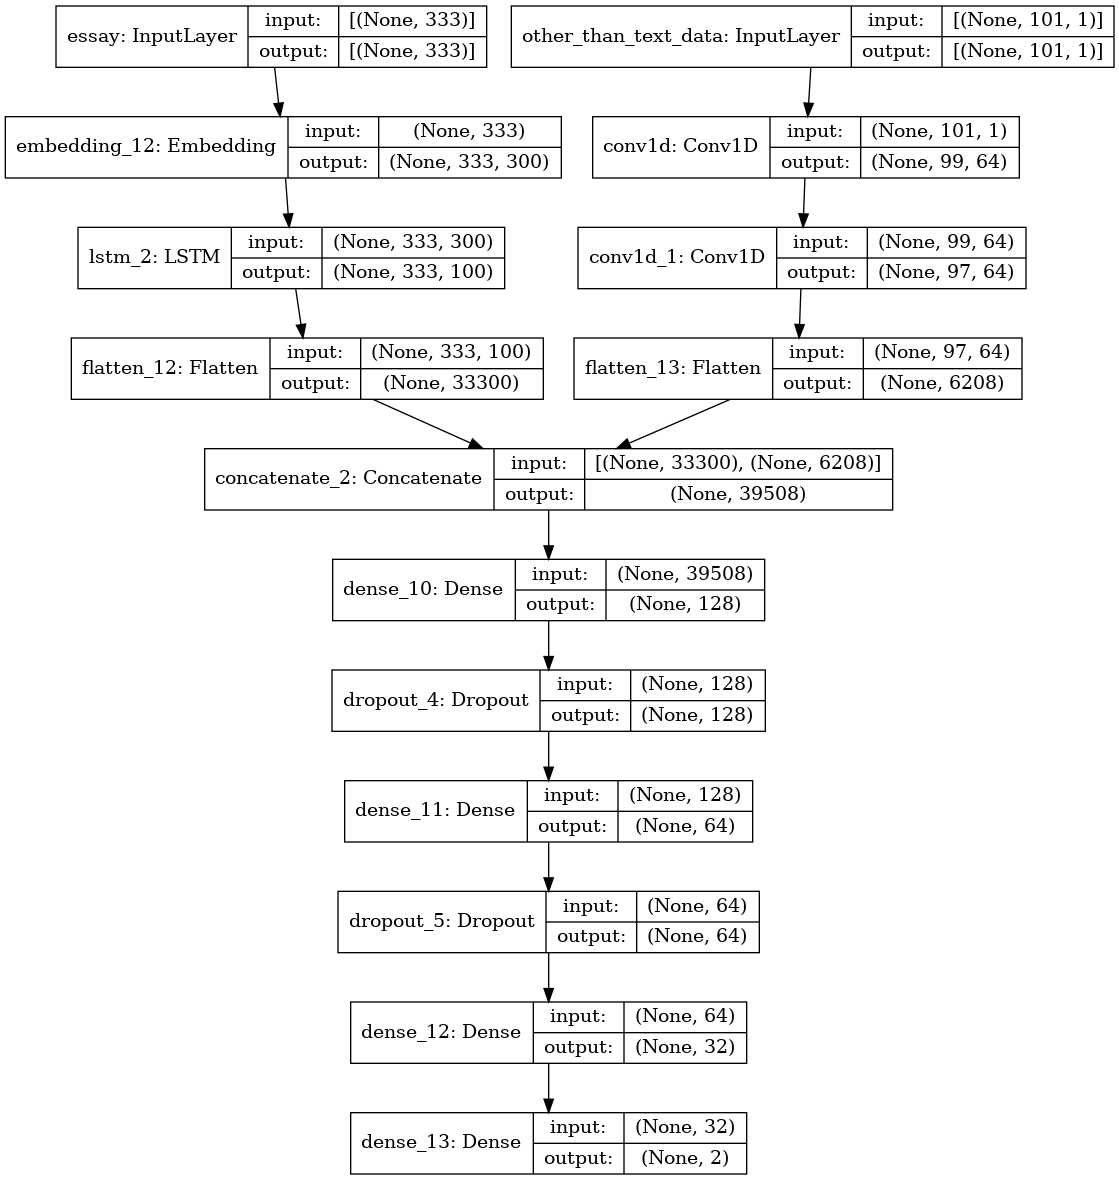

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model, "LSTM_3.png", show_shapes=True)

In [56]:
train_data_3 = [X_train_essay_pad, X_tr]
cv_data_3 = [X_cv_essay_pad, X_cv]
test_data_3 = [X_test_essay_pad, X_te]

In [57]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=[auc])

In [59]:
history = model.fit(train_data_3, y_train_ohe, batch_size=128, epochs=10, validation_data=(cv_data_3, y_cv_ohe)) 

Epoch 1/10


2023-01-19 00:25:18.703691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


419/419 [==============================] - 727s 2s/step - loss: 0.8658 - auc: 0.6603 - val_loss: 0.4690 - val_auc: 0.7163
Epoch 2/10
419/419 [==============================] - 715s 2s/step - loss: 0.4434 - auc: 0.7136 - val_loss: 0.4375 - val_auc: 0.7296
Epoch 3/10
419/419 [==============================] - 721s 2s/step - loss: 0.4169 - auc: 0.7237 - val_loss: 0.4059 - val_auc: 0.7360
Epoch 4/10
419/419 [==============================] - 694s 2s/step - loss: 0.4102 - auc: 0.7291 - val_loss: 0.4107 - val_auc: 0.7466
Epoch 5/10
419/419 [==============================] - 696s 2s/step - loss: 0.4064 - auc: 0.7349 - val_loss: 0.4159 - val_auc: 0.7375
Epoch 6/10
419/419 [==============================] - 687s 2s/step - loss: 0.4091 - auc: 0.7340 - val_loss: 0.4122 - val_auc: 0.7493
Epoch 7/10
419/419 [==============================] - 699s 2s/step - loss: 0.4066 - auc: 0.7393 - val_loss: 0.3999 - val_auc: 0.7537
Epoch 8/10
419/419 [==============================] - 696s 2s/step - loss: 0.402

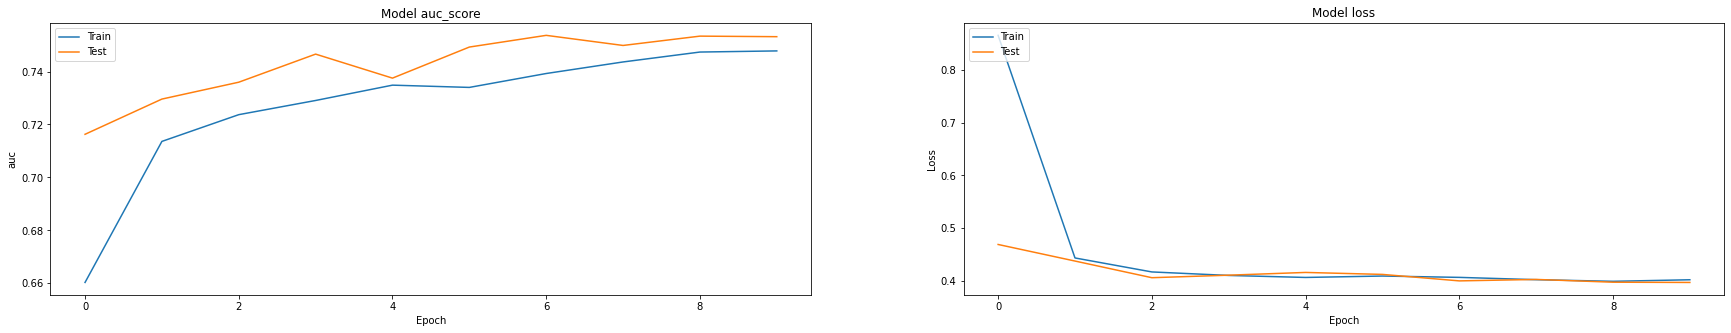

In [60]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc_score')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()